# Download dataset

In [ ]:
!wget https://scholar.cu.edu.eg/Dataset_BUSI.zip
!unzip Dataset_BUSI.zip
!pip install pytorch-gradcam

--2021-06-10 19:18:46--  https://scholar.cu.edu.eg/Dataset_BUSI.zip
Resolving scholar.cu.edu.eg (scholar.cu.edu.eg)... 195.246.42.194
Connecting to scholar.cu.edu.eg (scholar.cu.edu.eg)|195.246.42.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 205873341 (196M) [application/zip]
Saving to: ‘Dataset_BUSI.zip’

Dataset_BUSI.zip    100%[===================>] 196.34M   254KB/s    in 16m 23s 

2021-06-10 19:35:10 (204 KB/s) - ‘Dataset_BUSI.zip’ saved [205873341/205873341]

Archive:  Dataset_BUSI.zip
   creating: Dataset_BUSI_with_GT/
   creating: Dataset_BUSI_with_GT/benign/
  inflating: Dataset_BUSI_with_GT/benign/benign (1).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (1)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (10).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (10)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100)_mask.png  
  inflating: Dataset_BUS

# Import Libraries

In [ ]:
import os
import numpy as np
import random
from PIL import Image

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import ConcatDataset
import torchvision.transforms as transforms
from torchvision import models
from torchvision import utils
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from keras.utils.np_utils import to_categorical
from operator import truediv
import matplotlib.pyplot as plt
import seaborn as sb

from gradcam.utils import visualize_cam
from gradcam import GradCAMpp

# Initialize Constants

In [ ]:
LEARNING_RATE = 0.001
EPOCHS = 50
BATCH_SIZE = 20
NUM_OF_CLASSES = 3
LABELS = ['Normal', 'Benign', 'Malignant']
PRETRAIN = True
MODEL_NAME = 'resnet34' # 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152'

CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda") if CUDA else torch.device("cpu")
FILENAME = "_".join([MODEL_NAME, 'PRETRAIN', str(PRETRAIN)])

In [ ]:
ROOT = os.path.join('Dataset_BUSI_with_GT')
NORMAL = os.path.join(ROOT, 'normal')
BENIGN = os.path.join(ROOT, 'benign')
MALG = os.path.join(ROOT, 'malignant')

if not os.path.exists("Results"):
    os.makedirs("Results")

# Load Images

In [ ]:
X = []
Y = []

In [ ]:
for i in os.listdir(NORMAL):
  if 'mask' not in i:
    img_path = os.path.join(NORMAL, i)
    img = Image.open(img_path)
    img = np.array(img.resize((224, 224)))
    X.append(img)
    Y.append(0)

In [ ]:
for i in os.listdir(BENIGN):
  if 'mask' not in i:
    img_path = os.path.join(BENIGN, i)
    img = Image.open(img_path)
    img = np.array(img.resize((224, 224)))
    X.append(img)
    Y.append(1)

In [ ]:
for i in os.listdir(MALG):
  if 'mask' not in i:
    img_path = os.path.join(MALG, i)
    img = Image.open(img_path)
    img = np.array(img.resize((224, 224)))
    X.append(img)
    Y.append(2)

In [ ]:
X = np.array(X)
Y = np.array(Y)

print(X.shape, Y.shape)

(780, 224, 224, 3) (780,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=1, stratify=Y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.17647, random_state=1, stratify=y_train)

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape) #0.17647 0.0588235

(546, 224, 224, 3) (117, 224, 224, 3) (117, 224, 224, 3) (546,) (117,) (117,)


# Custom Transforms

In [ ]:
class TrainTransform(object):
  def __call__(self, sample):
    image_transformations = transforms.Compose([
                                          transforms.ToPILImage(),
                                          transforms.ToTensor(),
                                          transforms.Normalize(
                                              mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225]
                                              )
                                          ])

    image, label = sample['image'], sample['label']
    transformed_image = image_transformations(image)
    transformed_label = to_categorical(label, num_classes=NUM_OF_CLASSES)

    transformed_sample = {
        'image': transformed_image,
        'label': transformed_label
    }
    return transformed_sample

In [ ]:
class TestTransform(object):
  def __call__(self, sample):
    image_transformations = transforms.Compose([
                                          transforms.ToPILImage(),
                                          transforms.ToTensor(),
                                          transforms.Normalize(
                                              mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225]
                                              )
                                          ])

    image, label = sample['image'], sample['label']
    transformed_image = image_transformations(image)
    transformed_label = to_categorical(label, num_classes=NUM_OF_CLASSES)

    transformed_sample = {
        'image': transformed_image,
        'label': transformed_label
    }
    return transformed_sample

# Dataset

In [ ]:
class BUSIDataset(Dataset):
  def __init__(self, images, labels, transform=None):
    self.images = images
    self.labels = labels
    self.transform = transform
  
  def __len__(self):
    return self.images.shape[0]

  def __getitem__(self, index):
    image = self.images[index]
    label = self.labels[index]

    data = {'image':image, 'label':label}

    if self.transform:
      data = self.transform(data)
    return data

In [ ]:
def create_train_val_test_loaders(batch_size=BATCH_SIZE):  
  train_set = BUSIDataset(X_train, y_train, transform=TrainTransform())
  val_set = BUSIDataset(X_val, y_val, transform=TestTransform())
  test_set = BUSIDataset(X_test, y_test, transform=TestTransform())

  train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
  test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

In [ ]:
train_loader, val_loader, test_loader = create_train_val_test_loaders()
for batch in test_loader:
  print(batch['image'].shape, batch['label'].shape)

torch.Size([20, 3, 224, 224]) torch.Size([20, 3])
torch.Size([20, 3, 224, 224]) torch.Size([20, 3])
torch.Size([20, 3, 224, 224]) torch.Size([20, 3])
torch.Size([20, 3, 224, 224]) torch.Size([20, 3])
torch.Size([20, 3, 224, 224]) torch.Size([20, 3])
torch.Size([17, 3, 224, 224]) torch.Size([17, 3])


# Train-test utils

In [ ]:
def random_seed(i=0):
  torch.manual_seed(i)
  np.random.seed(i)
  random.seed(i)

  if CUDA:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
def test_model(model, test_loader, criterion, device):
  test_accuracy = 0
  test_loss = 0
  true_labels = []
  pred_labels = []

  model.eval()
  for batch in test_loader:
    image_batch = batch['image'].to(device)
    label_batch = batch['label'].to(device)
    _, label_batch = torch.max(label_batch, 1)

    y_pred = model(image_batch)
    batch_loss = criterion(y_pred, label_batch)

    _, output_labels = torch.max(y_pred, 1)
    correct = label_batch.eq(output_labels).cpu().numpy()

    test_accuracy += sum(correct)
    test_loss += batch_loss.item() * image_batch.size(0)

    true_labels += list(label_batch.cpu().numpy())
    pred_labels += list(output_labels.cpu().numpy())

  average_testing_loss = test_loss / len(test_loader.sampler)
  average_testing_accuracy = test_accuracy / len(test_loader.sampler)

  return average_testing_loss, average_testing_accuracy, true_labels, pred_labels

In [ ]:
def train_model(model, train_loader, val_loader, test_loader, optimizer, criterion, epochs, device, save_path):
  max_val_acc = 0

  train_losses = []
  test_losses = []
  val_losses = []

  train_accuracies = []
  test_accuracies = []
  val_accuracies = []

  for epoch in range(epochs):
    train_loss = 0
    test_loss = 0
    val_loss = 0

    train_accuracy = 0
    test_accuracy = 0
    val_accuracy = 0

    model.train()
    for batch in train_loader:
      image_batch = batch['image'].to(device)
      label_batch = batch['label'].to(device)
      _, label_batch = torch.max(label_batch, 1)

      optimizer.zero_grad()
      y_pred = model(image_batch)
      batch_loss = criterion(y_pred, label_batch)
      
      batch_loss.backward()
      optimizer.step()

      _, output_labels = torch.max(y_pred, 1)
      correct = label_batch.eq(output_labels).cpu().numpy()
      train_accuracy += sum(correct)
      train_loss += batch_loss.item() * image_batch.size(0)

    average_training_loss = train_loss / len(train_loader.sampler)
    average_training_accuracy = train_accuracy / len(train_loader.sampler)

    average_testing_loss, average_testing_accuracy, _, _ = test_model(
        model, test_loader, 
        criterion, device
        )

    average_val_loss, average_val_accuracy, _, _ = test_model(
        model, val_loader, 
        criterion, device
        )    
    
    train_losses.append(average_training_loss)
    test_losses.append(average_testing_loss)
    val_losses.append(average_val_loss)

    train_accuracies.append(average_training_accuracy)
    test_accuracies.append(average_testing_accuracy)
    val_accuracies.append(average_val_accuracy)

    # print('Epoch: {} \t Train Loss: {:.4f} \t Val Loss: {:.4f} \t Test Loss: {:.4f} \t Train Acc: {:.4f} \t Val Acc: {:.4f} \t Test Acc: {:.4f}'.format(epoch, average_training_loss, average_val_loss, average_testing_loss, average_training_accuracy, average_val_accuracy, average_testing_accuracy))
    
    if max_val_acc <= average_val_accuracy :
      print('Val Acc improved at epoch: {} \t Train Loss: {:.4f} \t Val Loss: {:.4f} \t Test Loss: {:.4f} \t Train Acc: {:.4f} \t Val Acc: {:.4f} \t Test Acc: {:.4f}'.format(epoch, average_training_loss, average_val_loss, average_testing_loss, average_training_accuracy, average_val_accuracy, average_testing_accuracy))
      max_val_acc = average_val_accuracy
      torch.save(model.state_dict(), save_path)      
  
  return train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies

# Define Models

In [ ]:
class Model(nn.Module):
  def __init__(self, name='resnet18', pretrained=False):
    super(Model, self).__init__()
    self.model = self.get_model(name, pretrained)

  def replace_fc(self, model):
    model.fc = nn.Linear(model.fc.in_features, NUM_OF_CLASSES)
    return model

  def get_model(self, name, pretrained):
    mapping = {
        'resnet18' : {
            'model' : models.resnet18,
            'replace' : self.replace_fc
        },
        'resnet34' : {
            'model' : models.resnet34,
            'replace' : self.replace_fc
        },
        'resnet50' : {
            'model' : models.resnet50,
            'replace' : self.replace_fc
        },
        'resnet101' : {
            'model' : models.resnet101,
            'replace' : self.replace_fc
        },
        'resnet152' : {
            'model' : models.resnet152,
            'replace' : self.replace_fc
        }
    }

    model = mapping[name]['replace'](mapping[name]['model'](pretrained=pretrained))
    return model

  def forward(self, x):
    x = self.model(x)
    return x

# Training Model

In [ ]:
print("Training Model")
random_seed(0)

model = Model(name=MODEL_NAME, pretrained=PRETRAIN).to(DEVICE)

train_loader, val_loader, test_loader = create_train_val_test_loaders(batch_size=BATCH_SIZE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

save_path = FILENAME + '_WEIGHTS.pt'

train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies = train_model(
      model=model, 
      train_loader=train_loader, 
      val_loader=val_loader,
      test_loader=test_loader, 
      optimizer=optimizer, 
      criterion=criterion, 
      epochs=EPOCHS, 
      device=DEVICE,
      save_path=save_path
      )
print("")

Training Model
Val Acc improved at epoch: 0 	 Train Loss: 0.9132 	 Val Loss: 3.7736 	 Test Loss: 4.2992 	 Train Acc: 0.6044 	 Val Acc: 0.6496 	 Test Acc: 0.5812
Val Acc improved at epoch: 2 	 Train Loss: 0.2399 	 Val Loss: 1.0778 	 Test Loss: 1.5117 	 Train Acc: 0.9212 	 Val Acc: 0.8376 	 Test Acc: 0.7863
Val Acc improved at epoch: 6 	 Train Loss: 0.0519 	 Val Loss: 0.7696 	 Test Loss: 0.7918 	 Train Acc: 0.9835 	 Val Acc: 0.8462 	 Test Acc: 0.8034
Val Acc improved at epoch: 17 	 Train Loss: 0.0131 	 Val Loss: 0.6680 	 Test Loss: 0.6288 	 Train Acc: 0.9945 	 Val Acc: 0.8462 	 Test Acc: 0.8718
Val Acc improved at epoch: 36 	 Train Loss: 0.0092 	 Val Loss: 0.7723 	 Test Loss: 0.9271 	 Train Acc: 0.9963 	 Val Acc: 0.8632 	 Test Acc: 0.8120
Val Acc improved at epoch: 44 	 Train Loss: 0.0063 	 Val Loss: 0.8170 	 Test Loss: 1.2855 	 Train Acc: 0.9982 	 Val Acc: 0.8632 	 Test Acc: 0.7949
Val Acc improved at epoch: 46 	 Train Loss: 0.0023 	 Val Loss: 0.5634 	 Test Loss: 1.0644 	 Train Acc: 1.0

# Testing & Visualization

In [ ]:
def generate_acc_plots(filename="file"):
  filename = os.path.join("Results", filename)
  xticks = [int(i) for i in list(range(EPOCHS))]

  # plt.grid(None)  
  plt.figure(figsize=(12, 4))
  sb.set(font_scale=1.2)

  plt.plot(xticks, train_accuracies, 'r-', linewidth=3, label='Train Accuracy')
  plt.plot(xticks, val_accuracies, 'b-', linewidth=3, label='Val Accuracy')
  plt.plot(xticks, test_accuracies, 'g-', linewidth=3, label='Test Accuracy')
  
  plt.legend(loc='best')
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.xticks(ticks=list(range(0, EPOCHS, 5)))
  plt.savefig(filename + '_accuracy.png', bbox_inches='tight')

  plt.show()

In [ ]:
def generate_loss_plots(filename="file"):
  filename = os.path.join("Results", filename)
  xticks = [int(i) for i in list(range(EPOCHS))]

  # plt.grid(None)
  plt.figure(figsize=(12, 4))  
  sb.set(font_scale=1.2)

  plt.plot(xticks, train_losses, 'r-', linewidth=3, label='Train Loss')
  plt.plot(xticks, val_losses, 'b-', linewidth=3, label='Val Loss')
  plt.plot(xticks, test_losses, 'g-', linewidth=3, label='Test Loss')
  
  plt.legend(loc='best')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.xticks(ticks=list(range(0, EPOCHS, 5)))
  plt.savefig(filename + '_loss.png', bbox_inches='tight')

  plt.show()

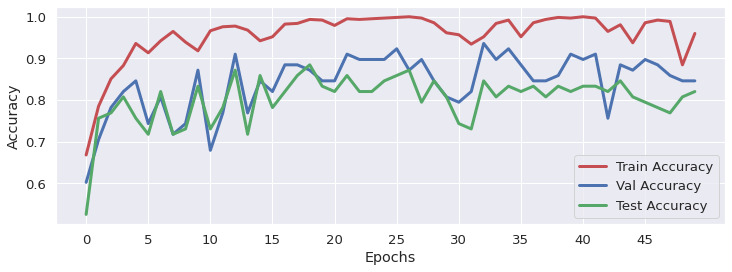

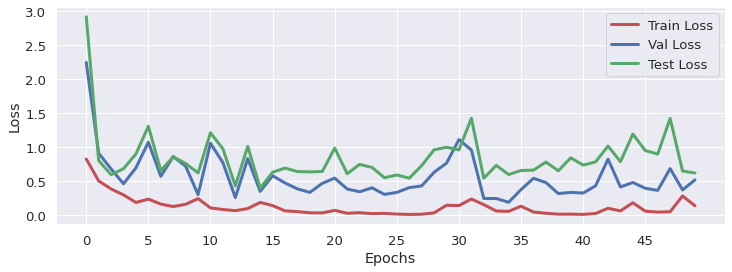

In [ ]:
generate_acc_plots(FILENAME)
generate_loss_plots(FILENAME)

In [ ]:
def ClassWiseAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)

    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    each_acc_dict = dict(zip(LABELS, each_acc*100))

    return each_acc_dict

In [ ]:
def reports(y_pred, y_true):    
    c_report = classification_report(y_true, y_pred, digits=4, target_names=LABELS)
    accuracy = accuracy_score(y_true, y_pred)

    confusion = confusion_matrix(y_true, y_pred) #, normalize='all'
    each_acc = ClassWiseAccuracy(confusion)

    return c_report, confusion, accuracy*100, each_acc

In [ ]:
def generate_results(c_report, each_acc, accuracy, file_name = "classification_report.txt"):

  file_name = os.path.join("Results", file_name)

  c_report = str(c_report)
  each_acc = str(each_acc)

  with open(file_name, 'w') as x_file:
    x_file.write('\n')
    x_file.write('{} is accuracy in (%)'.format(accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('Classification Report - \n')
    x_file.write('{}'.format(c_report))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('Class-Wise Accuracies - \n')
    x_file.write('{}'.format(each_acc))

In [ ]:
def generate_confusion_matrix(cm, filename="cm.png"):
  filename = os.path.join("Results", filename)
  sb.set(font_scale=1.2)

  plt.figure(figsize=(6, 2))
  plt.axis('on')
  ax = sb.heatmap(cm, annot=True, linewidths=0.5,
             xticklabels=LABELS, yticklabels=LABELS, cmap='YlOrRd') 
  
  #fmt="d", cbar_kws={"ticks":[0.2, 0.4, 0.6, 0.8]}, vmin = 0.0, vmax=1.0,
             
  for _, spine in ax.spines.items():
    spine.set_visible(True)

  plt.savefig(filename, bbox_inches='tight')
  plt.show()

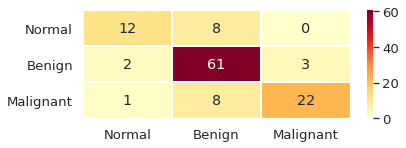

Results Generated 


In [ ]:
accuracies = []
each_accs = []

# model = Model(name=MODEL_NAME, pretrained=PRETRAIN).to(DEVICE)
weights_path = FILENAME + '_WEIGHTS.pt'
model.load_state_dict(torch.load(weights_path))

_, _, y_true, y_pred = test_model(
      model=model, 
      test_loader=test_loader, 
      criterion=criterion, 
      device=DEVICE
      )

c_report, confusion, accuracy, each_acc = reports(y_pred, y_true)

accuracies.append(accuracy)
each_accs.append(list(each_acc.values()))

generate_results(c_report, each_acc, accuracy, file_name=FILENAME+'.txt')
generate_confusion_matrix(confusion, filename=FILENAME+'.png')
print("Results Generated ")

In [ ]:
def read_cam_image(image):

  torch_img = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
  ])(image).to(DEVICE)

  normed_torch_img = transforms.Normalize(
      [0.485, 0.456, 0.406], 
      [0.229, 0.224, 0.225])(torch_img)[None]

  return torch_img, normed_torch_img

In [ ]:
def get_target_layer():
  layers = []
  for i in model.model.children():
    layers.append(i)
  
  return layers[-3]

In [ ]:
def generate_gradcam(model, number_of_images, columns, figsize, label=0, filename="CAM.png"):
  filename = filename + "_CLASS_" + str(LABELS[label]) + ".png"
  filename = os.path.join("Results", filename)
  indices = np.arange(X_train.shape[0])
  np.random.shuffle(indices)

  images = X_train[indices]
  labels = y_train[indices]  
  images = [images[i] for i in range(images.shape[0]) if labels[i] == label]

  print("CAM visualization for " + LABELS[label] + " images")
  images_cam = []

  for index in range(number_of_images):
    torch_img, normed_torch_img = read_cam_image(images[index])

    target_layer = get_target_layer() #model.model.avgpool
    gradcam = GradCAMpp(model, target_layer)
    mask, _ = gradcam(normed_torch_img)

    heatmap, result_cam = visualize_cam(mask, torch_img)
    images_cam.append(utils.make_grid([torch_img.cpu(), result_cam], nrow=3, padding=1))

  image_grid = utils.make_grid(images_cam, nrow=columns, padding=5, pad_value=1)

  plt.figure(figsize=figsize)
  plt.imshow(transforms.ToPILImage()(image_grid))

  plt.axis('off')
  plt.savefig(filename, bbox_inches='tight')
  plt.show()

  return image_grid

CAM visualization for Normal images


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


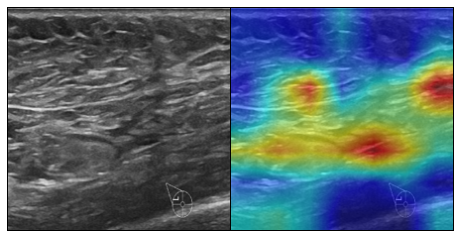

In [ ]:
image_grid = generate_gradcam(model, number_of_images=1, columns=1, figsize=(8, 8), label=0, filename=FILENAME)

CAM visualization for Benign images


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


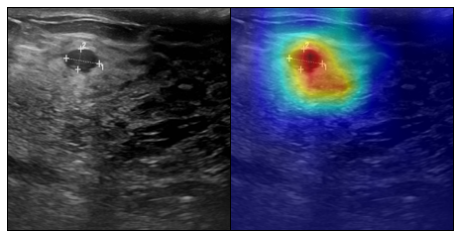

In [ ]:
image_grid = generate_gradcam(model, number_of_images=1, columns=1, figsize=(8, 8), label=1, filename=FILENAME)

CAM visualization for Malignant images


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


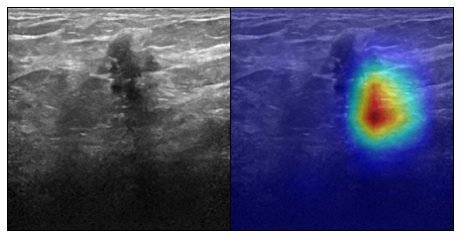

In [ ]:
image_grid = generate_gradcam(model, number_of_images=1, columns=1, figsize=(8, 8), label=2, filename=FILENAME)